## Checkee.info Data Analysis
Some very simple data analysis of the scraped data from [Checkee.info](http://checkee.info/).

I am also using this data set to practice how to use the Pandas library in Python 3.

*Note that due to the limitations of the dataset, the results are not likely to be reliable and can only be used as an overview.*

In [115]:
# xlrd to read .xlsx sheet data
import xlrd
from xlrd.xldate import xldate_as_datetime

# Import Pandas library
import pandas as pd

# Import plotly
import plotly.offline as py
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Import numpy
import numpy as np

# Import stats methods for statistical analysis
from scipy.stats import norm, normaltest, gamma

# Make sure plots are inline
#%matplotlib inline

In [2]:
# Global Parameters
MAX_CASE_LENGTH = 7 * 14  # Maximum allowed case length is 14 weeks

In [3]:
# Read scraped datasheet
workbook = xlrd.open_workbook('VISA-Data-2018-04-05.xlsx')
booksheet = workbook.sheet_by_index(0)

# Get data fields
startRow = 1
userID = booksheet.col_values(0,startRow)
visaType = booksheet.col_values(2,startRow)
visaEntry = booksheet.col_values(3,startRow)
city = booksheet.col_values(4,startRow)
waitDays = booksheet.col_values(9,startRow)

# By default, xlrd will read the date fields into numeric values (xldate type)
# So here I need to convert xldate into datetime type
dateNum = booksheet.col_values(7,startRow)
checkDate = []
for item in dateNum:
    checkDate.append(xldate_as_datetime(item,0))

In [116]:
# Assemble all the data into a Pandas.DataFrame object
df = pd.DataFrame({
        'UserID'    : pd.Series(userID, dtype=int),
        'VisaType'  : pd.Categorical(visaType),
        'VisaEntry' : pd.Categorical(visaEntry),
        'City'      : pd.Categorical(city),
        'CheckDate' : pd.Series(checkDate),
        'Year'      : pd.Series([d.year for d in checkDate]),
        'Month'     : pd.Series([d.month for d in checkDate]),
        'WaitDays'  : pd.Series(waitDays, dtype=int),
        'WaitWeeks' : pd.Series([np.ceil(x/7) for x in waitDays], dtype=int)
        })

# Use userID as the index
df = df.set_index('UserID')

# Show raw data
#df.tail()
tbl = ff.create_table(df.tail(10))
py.iplot(tbl, show_link = False)

As shown above, the raw data includs a couple of fields:
- **checkDate** - When the applicant applied for visa
- **city** - Where did the application submitted
- **userID** - An unique annonymous user identifier
- **visaEntry** - Is the application new or renewal
- **visaType** - Type of visa applied
- **waitDays** - How long did it take to finally get the visa

Note that all the data here are those marked as complete.

In [124]:
# Group data by Visa Type
vt = df.groupby('VisaType')['VisaType'].count()

# Group data by wait days
wd = df.groupby('VisaType')['WaitDays'].mean()

# Summarize Data Population
#fig = tools.make_subplots(rows=1, cols=2, 
#                         subplot_titles=('Population size', 
#                                         'Average check weeks'))
# Pie chart - Population by Visa type
trace1 = go.Pie(labels=vt.index.values, values=vt.values)
py.iplot([trace1])

# Bar chart - Average check days by Visa type
trace2 = go.Bar(x=wd.index.values,
                y=wd.values)
layout = go.Layout(
    title='Average check days by Visa type',
    xaxis=dict(
        autorange=True,
        autotick=True,
        title='Visa Type'
    ),
    yaxis=dict(
        autorange=True,
        autotick=False,
        tick0=0,
        dtick=7,
        title='Average Check Days'
    )
)
fig = go.Figure(data=[trace2], layout=layout)
py.iplot(fig, show_link=False)

Facts based on population:
- F1 visa have most records ($n=7992$)
- J1 has the second largest records ($n=3039$), followed by H1 ($n=2454$)
- B1 and B2 together has $n=2189$ records.

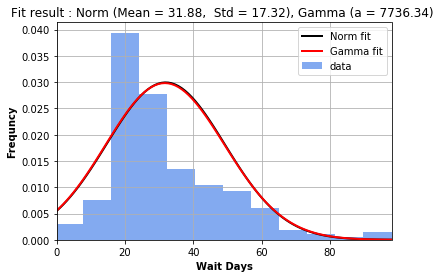

In [6]:
# Get F1 Visa waiting days data
wdF1 = wd.get_group('F1')

# Clip irregular values (more than 14 weeks)
wdF1 = wdF1.clip_upper(MAX_CASE_LENGTH)

# Try to fit a normal distribution
mu, std = norm.fit(wdF1.values)
# and gamma distribution
a, l, s = gamma.fit(wdF1.values)

# Plot histogram overlayed with normal distribution fit
wdF1.hist(bins=50, density=True, alpha=0.8, color='#6495ED')
plt.xlabel('Wait Days',fontweight='bold')
plt.ylabel('Frequncy',fontweight='bold')
# overlay - Normal Distribution
x = np.linspace(0, MAX_CASE_LENGTH, 100)
p = norm.pdf(x, mu, std) * 1.3
plt.plot(x, p, 'k', linewidth=2)
title = "Fit result : Norm (Mean = %.2f,  Std = %.2f), Gamma (a = %.2f) " % (mu, std, a)
plt.title(title)
# overlay - Gamma Distribution
p = gamma.pdf(x, a, loc=l, scale=s) * 1.3
plt.plot(x, p, 'r', linewidth=2)

plt.legend(['Norm fit','Gamma fit','data'])
plt.tick_params(labelleft=True)
plt.xlim(0, MAX_CASE_LENGTH)
plt.show()

In [7]:
# Let's first make sure it comes from a normal distribution by conducting a Chi-squared test
_, pval = normaltest(wdF1.values)
print('Chi-Squared test p = %.10f' % pval)

# Estimate 95% confidence interval by taking [mu-2*SE, mu+2*SE] (assume normal distribution)
interval = norm.interval(0.95, loc=mu, scale=std/np.sqrt(wdF1.count()))
print('95%% CI of waiting days: (%.3f, %.3f)' % (interval[0], interval[1]))

Chi-Squared test p = 0.0000000000
95% CI of waiting days: (31.460, 32.297)


The plot above shows the histogram and fitted distribution based on all the F1 visa records available ($n=7992$). Here are some interpretations:
- Sample mean ($\mu=32.04$) suggest the the average waiting days for F1 visa applicant being checked is around 32.04 days. Specifically, 95% confidence interval is **(31.667, 32.419) days**
- Sample has a rather large standard deviation ($\sigma=17.14$). One standard deviation range ($\mu\pm\sigma$, *i.e.* ~68% of the population) is (14.9, 49.18) days which is about **2 to 7 weeks**. In addition, two standard deviation range ($\mu\pm2\sigma$, *i.e.* ~95% of the population) is (-2.24, 66.33) days which is about **0 to 9 weeks**.
- Based on the fitted curves, a gamma (skewed distribution) looks visually better than a normal fit which implies two things. First, the mean is skewed towards the left means there are more people get cleared within 32 days (sample mean). Second, distribution has a rather long tail on the right which suggest those people like me who unformatunately got checked longer than the mean **tend to be very long (e.g. I got checked for 49 days)**.